This notebook was written by [Mitchell Johnson](https://www.johnsonmitchelld.com/). The source code, as well as the gnssutils Python package containing the EphemerisManager module, can be found on [Github](https://github.com/johnsonmitchelld/gnss-analysis).

In [1]:
os.chdir('..')
import sys, os, csv
import pandas as pd
import numpy as np
import navpy
from gnssutils import EphemerisManager

Let's read in a GNSS log file, format the satellite IDs to match up with the RINEX 3.0 standard, and convert the columns we need to calculate receiver position to numeric values. We'll also filter the data so that we're only working with GPS measurements to simplify the rest of the analysis.

In [2]:
# Get path to sample file in data directory, which is located in the parent directory of this notebook
input_filepath = os.path.join(os.getcwd(), 'data', 'sample', 'gnss_log_2020_12_02_17_19_39.txt')

with open(input_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row[0][0] == '#':
            if 'Fix' in row[0]:
                android_fixes = [row[1:]]
            elif 'Raw' in row[0]:
                measurements = [row[1:]]
        else:
            if row[0] == 'Fix':
                android_fixes.append(row[1:])
            elif row[0] == 'Raw':
                measurements.append(row[1:])

android_fixes = pd.DataFrame(android_fixes[1:], columns = android_fixes[0])
measurements = pd.DataFrame(measurements[1:], columns = measurements[0])

# Format satellite IDs
measurements.loc[measurements['Svid'].str.len() == 1, 'Svid'] = '0' + measurements['Svid']
measurements.loc[measurements['ConstellationType'] == '1', 'Constellation'] = 'G'
measurements.loc[measurements['ConstellationType'] == '3', 'Constellation'] = 'R'
measurements['SvName'] = measurements['Constellation'] + measurements['Svid']

# Remove all non-GPS measurements
measurements = measurements.loc[measurements['Constellation'] == 'G']

# Convert columns to numeric representation
measurements['Cn0DbHz'] = pd.to_numeric(measurements['Cn0DbHz'])
measurements['TimeNanos'] = pd.to_numeric(measurements['TimeNanos'])
measurements['FullBiasNanos'] = pd.to_numeric(measurements['FullBiasNanos'])
measurements['ReceivedSvTimeNanos']  = pd.to_numeric(measurements['ReceivedSvTimeNanos'])
measurements['PseudorangeRateMetersPerSecond'] = pd.to_numeric(measurements['PseudorangeRateMetersPerSecond'])
measurements['ReceivedSvTimeUncertaintyNanos'] = pd.to_numeric(measurements['ReceivedSvTimeUncertaintyNanos'])
if 'BiasNanos' in measurements.columns:
    measurements['BiasNanos'] = pd.to_numeric(measurements['BiasNanos'])
else:
    measurements['BiasNanos'] = 0
if 'TimeOffsetNanos' in measurements.columns:
    measurements['TimeOffsetNanos'] = pd.to_numeric(measurements['TimeOffsetNanos'])
else:
    measurements['TimeOffsetNanos'] = 0

print(measurements.columns)

Index(['ElapsedRealtimeMillis', 'TimeNanos', 'LeapSecond',
       'TimeUncertaintyNanos', 'FullBiasNanos', 'BiasNanos',
       'BiasUncertaintyNanos', 'DriftNanosPerSecond',
       'DriftUncertaintyNanosPerSecond', 'HardwareClockDiscontinuityCount',
       'Svid', 'TimeOffsetNanos', 'State', 'ReceivedSvTimeNanos',
       'ReceivedSvTimeUncertaintyNanos', 'Cn0DbHz',
       'PseudorangeRateMetersPerSecond',
       'PseudorangeRateUncertaintyMetersPerSecond',
       'AccumulatedDeltaRangeState', 'AccumulatedDeltaRangeMeters',
       'AccumulatedDeltaRangeUncertaintyMeters', 'CarrierFrequencyHz',
       'CarrierCycles', 'CarrierPhase', 'CarrierPhaseUncertainty',
       'MultipathIndicator', 'SnrInDb', 'ConstellationType', 'AgcDb',
       'CarrierFrequencyHz', 'Constellation', 'SvName'],
      dtype='object')


Those with experience in GNSS data processing will probably notice that we're missing a few important fields for calculating receiver position.

First, we'll calculate the GPS time in nanoseconds using the equations from Section 2.4 of the European Global Navigation Satellite Systems Agency's [white paper](https://www.gsa.europa.eu/system/files/reports/gnss_raw_measurement_web_0.pdf). Then we'll convert it to a normal Unix timestamp using the Pandas.to_datetime() function with the GPS reference epoch.

**An aside on timestamps:** note that the UTC flag is set to True in the Pandas.to_datetime() method. The timestamp column needs to be timezone-aware, because we're eventually going to plug it into the Python datetime library and use it to format the ephemeris filepath for download from NASA. The EphemerisManager module compares the timestamp with the current time to determine which files to retrieve. Since the datetime library defaults to local time on some systems, it was necessary to keep everything timezone-aware to avoid mix-ups.

This nomenclature is a bit confusing since we're using the method to create a column called UnixTime. Unix time and UTC are technically in the same time zone, but UTC includes leap seconds, while Unix time does not. Since we're creating a timestamp from the number of seconds elapsed since the GPS epoch, the resulting timestamp could differ from UTC by some number of leap seconds. That's close enough to ensure we get the correct ephemeris file, and it won't affect the actual position calculations because we don't use the UnixTime column for those.

Finally, let's split the data into measurement epochs. We do this by creating a new column and setting it to 1 whenever the difference between a timestamp and the previous timestamp is greater than 200 milliseconds using the DataFrame.shift() command. Then we use the cumsum method to generate unique numbers for the individual epochs.

In [4]:
from datetime import datetime, timezone, timedelta

measurements['GpsTimeNanos'] = measurements['TimeNanos'] - (measurements['FullBiasNanos'] - measurements['BiasNanos'])
gpsepoch = datetime(1980, 1, 6, 0, 0, 0)
measurements['UnixTime'] = pd.to_datetime(measurements['GpsTimeNanos'], utc = True, origin=gpsepoch)
measurements['UnixTime'] = measurements['UnixTime']

# Split data into measurement epochs
measurements['Epoch'] = 0
measurements.loc[measurements['UnixTime'] - measurements['UnixTime'].shift() > timedelta(milliseconds=200), 'Epoch'] = 1
measurements['Epoch'] = measurements['Epoch'].cumsum()

Next let's calculate the estimated signal transmission and reception times. From those we'll calculate the pseudorange for each satellite in both seconds and meters.

In [5]:
WEEKSEC = 604800
LIGHTSPEED = 2.99792458e8

# This should account for rollovers since it uses a week number specific to each measurement

measurements['tRxGnssNanos'] = measurements['TimeNanos'] + measurements['TimeOffsetNanos'] - (measurements['FullBiasNanos'].iloc[0] + measurements['BiasNanos'].iloc[0])
measurements['GpsWeekNumber'] = np.floor(1e-9 * measurements['tRxGnssNanos'] / WEEKSEC)
measurements['tRxSeconds'] = 1e-9*measurements['tRxGnssNanos'] - WEEKSEC * measurements['GpsWeekNumber']
measurements['tTxSeconds'] = 1e-9*(measurements['ReceivedSvTimeNanos'] + measurements['TimeOffsetNanos'])
measurements['prSeconds'] = measurements['tRxSeconds'] - measurements['tTxSeconds']
measurements['PrM'] = LIGHTSPEED * measurements['prSeconds']
measurements['PrSigmaM'] = LIGHTSPEED * 1e-9 * measurements['ReceivedSvTimeUncertaintyNanos']

Now that we have pseudorange values, we can begin the standard process for calculating receiver position. First we need to retrieve the ephemeris data for each satellite from one of the International GNSS Service (IGS) analysis centers. These include NASA's [CDDIS](https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/orbit_products.html) and the German [BKG](https://igs.bkg.bund.de/dataandproducts/index).

This process is, frankly, a bit of a pain, so I wrote a Python module to handle the details. You can view the code and documentation [here](https://github.com/johnsonmitchelld/gnss-analysis/tree/main/gnssutils).

In [6]:
manager = EphemerisManager()

epoch = 10
timestamp = measurements.iloc[epoch]['UnixTime'].to_pydatetime(warn=False)
one_epoch = measurements.loc[(measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)].drop_duplicates(subset='SvName')
one_epoch.set_index('SvName', inplace=True)

sats = one_epoch.index.unique().tolist()
ephemeris = manager.get_ephemeris(timestamp, sats)

Retrieving gnss/data/daily/2020/brdc/brdc3380.20n.gz from gdc.cddis.eosdis.nasa.gov


Calculating satellite position from ephemeris data is a bit involved, but the details are conveniently laid out in Tables 20-III and 20-IV of the GPS [Interface Specification Document](https://www.gps.gov/technical/icwg/IS-GPS-200L.pdf). The function below performs this calculation, taking a Pandas dataframe with the ephemeris parameters for every satellite and a dataseries containing the transmit time for all received signals in seconds since the start of the current GPS week. It also calculates the satellite clock offsets for the given transmission time.

In [7]:
def calculate_satellite_position(ephemeris, transmit_time):
    mu = 3.986005e14
    OmegaDot_e = 7.2921151467e-5
    F = -4.442807633e-10
    sv_position = pd.DataFrame()
    sv_position['sv']= ephemeris.index
    sv_position.set_index('sv', inplace=True)
    sv_position['t_k'] = transmit_time - ephemeris['t_oe']
    A = ephemeris['sqrtA'].pow(2)
    n_0 = np.sqrt(mu / A.pow(3))
    n = n_0 + ephemeris['deltaN']
    M_k = ephemeris['M_0'] + n * sv_position['t_k']
    E_k = M_k
    err = pd.Series(data=[1]*len(sv_position.index))
    i = 0
    while err.abs().min() > 1e-8 and i < 10:
        new_vals = M_k + ephemeris['e']*np.sin(E_k)
        err = new_vals - E_k
        E_k = new_vals
        i += 1
        
    sinE_k = np.sin(E_k)
    cosE_k = np.cos(E_k)
    delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
    delT_oc = transmit_time - ephemeris['t_oc']
    sv_position['delT_sv'] = ephemeris['SVclockBias'] + ephemeris['SVclockDrift'] * delT_oc + ephemeris['SVclockDriftRate'] * delT_oc.pow(2)

    v_k = np.arctan2(np.sqrt(1-ephemeris['e'].pow(2))*sinE_k,(cosE_k - ephemeris['e']))

    Phi_k = v_k + ephemeris['omega']

    sin2Phi_k = np.sin(2*Phi_k)
    cos2Phi_k = np.cos(2*Phi_k)

    du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
    dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
    di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

    u_k = Phi_k + du_k

    r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k

    i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

    x_k_prime = r_k*np.cos(u_k)
    y_k_prime = r_k*np.sin(u_k)

    Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

    sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
    sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
    sv_position['z_k'] = y_k_prime*np.sin(i_k)
    return sv_position

# Run the function and check out the results:
sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'])
print(sv_position)

             t_k   delT_sv           x_k           y_k           z_k
sv                                                                  
G05  4807.354386 -0.000027 -2.171029e+07  4.560819e+06  1.458763e+07
G07  4807.362977 -0.000426 -3.694080e+06 -1.644564e+07  2.074283e+07
G08  4807.359065 -0.000002  7.366795e+06 -1.914142e+07  1.673248e+07
G09  4807.356809 -0.000297 -7.511545e+06 -2.536215e+07  2.217737e+06
G13  4807.353037  0.000071 -1.325052e+07  1.034195e+07  2.040048e+07
G14  4807.359710  0.000052 -2.109760e+07 -1.395420e+07  8.100629e+06
G27  4807.354121 -0.000027  1.341155e+07 -7.067973e+06  2.162338e+07
G28  4807.358301  0.000648 -2.236910e+07 -1.338034e+07  5.146993e+06
G30  4807.363223 -0.000346 -1.303756e+07 -9.355779e+06  2.123314e+07


We now have raw pseudorange values, satellite positions, and satellite clock offsets. Let's correct the pseudoranges for satellite clock bias and convert the values to Numpy arrays.

In [8]:
#initial guesses of receiver clock bias and position
b0 = 0
x0 = np.array([0, 0, 0])
xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()

# Apply satellite clock bias to correct the measured pseudorange values
pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
pr = pr.to_numpy()

Here's the function to calculate rough receiver position. Its inputs are Numpy arrays containing satellite positions in the ECEF frame, pseudorange measurements in meters, and initial estimates of receiver position and clock bias. The unit for clock bias is meters, so you need to divide by the speed of light to convert to seconds.

This function is adapted and simplified from the MATLAB code in Ankur Mohan's [blog](https://www.telesens.co/2017/07/17/calculating-position-from-raw-gps-data/). It's a simple least squares iteration with no correction for ionospheric delay or satellite movement during signal time of flight.

In [9]:
def least_squares(xs, pr, x0, b0):
    dx = 100*np.ones(3)
    b = b0
    # set up the G matrix with the right dimensions. We will later replace the first 3 columns
    # note that b here is the clock bias in meters equivalent, so the actual clock bias is b/LIGHTSPEED
    G = np.ones((pr.size, 4))
    iterations = 0
    while np.linalg.norm(dx) > 1e-3:
        norms = np.linalg.norm(xs - x0, axis=1)
        dp = pr - norms + b - b0
        G[:, 0:3] = -(xs - x0)/norms[:, None]
        sol = np.linalg.inv(np.transpose(G)@G) @ np.transpose(G) @ dp
        dx = sol[0:3]
        db = sol[3]
        norm_dp = np.linalg.norm(dp)
        x0 = x0 + dx
        b0 = b0 + db

    return x0, b0, norm_dp

x, b, dp = least_squares(xs, pr, x0, b0)
print(navpy.ecef2lla(x))
print(b/LIGHTSPEED)
print(dp)

(47.586270293121764, -122.32852029308533, 6.88566867262125)
-1.167561052244428e-07
13.68843891495611


Looks like it worked! The pseudorange residual is in the tens of meters, which is reasonable considering we didn't correct for ionospheric delay or the rotation of the Earth during signal transmission.

Now let's wrap this entire process into a loop to calculate receiver position for every measurement epoch in the dataset with more than 4 satellite measurements.



In [10]:
lla_list = []
ned_list = []
for epoch in measurements['Epoch'].unique():
    one_epoch = measurements.loc[(measurements['Epoch'] == epoch) & (measurements['prSeconds'] < 0.1)] 
    one_epoch = one_epoch.drop_duplicates(subset='SvName').set_index('SvName')
    if len(one_epoch.index) > 4:
        timestamp = one_epoch.iloc[0]['UnixTime'].to_pydatetime(warn=False)
        sats = one_epoch.index.unique().tolist()
        ephemeris = manager.get_ephemeris(timestamp, sats)
        sv_position = calculate_satellite_position(ephemeris, one_epoch['tTxSeconds'])

        xs = sv_position[['x_k', 'y_k', 'z_k']].to_numpy()
        pr = one_epoch['PrM'] + LIGHTSPEED * sv_position['delT_sv']
        pr = pr.to_numpy()

        x, b, dp = least_squares(xs, pr, x, b)
        lla = navpy.ecef2lla(x)
        lla_list.append(lla)
        ned_list.append(navpy.lla2ned(lla[0], lla[1], lla[2], lla_list[0][0], lla_list[0][1], lla_list[0][2]))

Finally, we'll convert the list of NED translations into a Pandas dataframe and create a plot of change in position relative to the first measurement epoch.

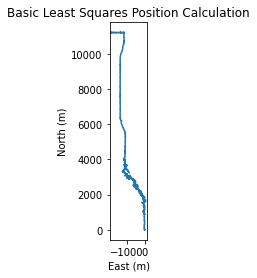

In [11]:
import matplotlib.pyplot as plt
ned_df = pd.DataFrame(ned_list, columns=['N', 'E', 'D'])
plt.plot(ned_df['E'], ned_df['N'])

# Add titles
plt.title('Basic Least Squares Position Calculation')
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.gca().set_aspect('equal', adjustable='box')